In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from os import listdir
import soundfile
from IPython.display import Audio
import random
import math
    
librosa.__version__

'0.8.0'

### Implementation of Mark Cartwright's listening test outlined in - 
```Cartwright, M., Pardo, B., Mysore, G., Hoffman, M. Fast and Easy Crowdsourced Perceptual Audio Evaluation. In Proceedings of the International Conference on Acoustics, Speech and Signal Processing (ICASSP), 2016.```

In [2]:
screening_sounds_dir = '/Users/purnimakamath/appdir/Github/listening_test_samples/neurips-2021/ui/screening_sounds'
step1_file = os.path.join(screening_sounds_dir, 'step1.wav')
step2_1_file = os.path.join(screening_sounds_dir, 'step2_1.wav')
step2_2_file = os.path.join(screening_sounds_dir, 'step2_2.wav')

step3_1_file = os.path.join(screening_sounds_dir, 'step3_1.wav')
step3_2_file = os.path.join(screening_sounds_dir, 'step3_2.wav')
step3_3_file = os.path.join(screening_sounds_dir, 'step3_3.wav')
step3_4_file = os.path.join(screening_sounds_dir, 'step3_4.wav')
step3_5_file = os.path.join(screening_sounds_dir, 'step3_5.wav')
step3_6_file = os.path.join(screening_sounds_dir, 'step3_6.wav')
step3_7_file = os.path.join(screening_sounds_dir, 'step3_7.wav')

In [3]:
def applyFadeFilter(fadetime,signal,fs): #0.65secs
    num_fad_samp = int(fadetime*fs)
    signal_length = len(signal)
    fadefilter = np.ones(signal_length)
    if num_fad_samp>0:
        fadefilter[0:num_fad_samp]=np.linspace(0,1,num_fad_samp)
        fadefilter[signal_length-num_fad_samp:signal_length]=np.linspace(1,0,num_fad_samp)

    return fadefilter*signal

In [4]:
def get_sine(a, f, fs, t):
    data = a * np.sin(2* np.pi * f * np.arange(int(fs*t))/fs)
    data = applyFadeFilter(0.1, data, fs)
    return data

In [75]:
def normalize(audio, rms_level=0):
    r = 10**(rms_level / 10.0)
    a = np.sqrt( (len(audio) * r**2) / np.sum(audio**2) )
    y = audio * a
    return y

In [76]:
#Step 1 : Adjust volume to a comfortable level using this sine tone
vol_sine_tone = get_sine(1.0, 1000, 16000, 5)
soundfile.write(step1_file, vol_sine_tone, samplerate=16000)
Audio(vol_sine_tone, rate=16000)

Number of tones in test audio (including 55 Hz and 10kHz) =  3
Frequencies selected =  [  100.     0.     0.     0. 10000.     0.     0.  5348.]
[0.         0.00010612 0.00042414 ... 0.         0.         0.        ]


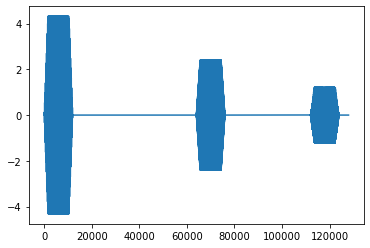

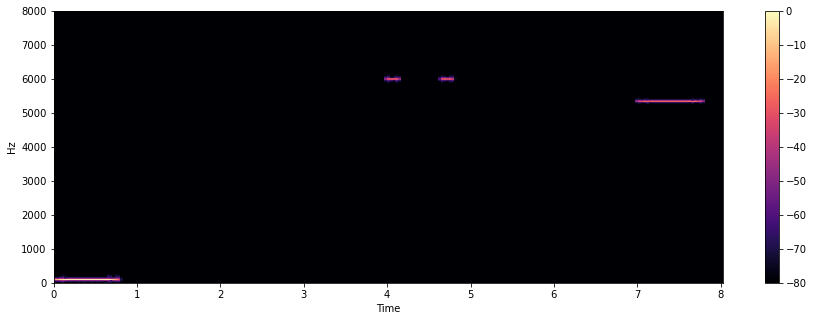

In [86]:
# Step 2: Count the number of tones you hear in this clip - 2 TONES
lower_bound = 100
upper_bound = 10000
num_tones = random.choice(range(0, 6, 1))
fs = 16000
duration = 0.75

frequency_indexes = np.zeros(8)

lower_bound_index = random.choice(range(0, 3, 1))
frequency_indexes[lower_bound_index] = lower_bound
upper_bound_index = random.choice(range(3, 7, 1))
frequency_indexes[upper_bound_index] = upper_bound

for ind in range(num_tones):
    ind_choice = random.choice(np.where(frequency_indexes == 0)[0])
    f = random.choice(range(lower_bound, upper_bound, 1))
    frequency_indexes[ind_choice] = f

test_tone = np.array([])
for ind in range(len(frequency_indexes)):
    d = get_sine(1.0, frequency_indexes[ind], fs, 0.75)
    test_tone = np.append(test_tone, d)
    d = get_sine(1.0, 0, fs, 0.25)
    test_tone = np.append(test_tone, d)
    if frequency_indexes[ind] != 0:
        test_tone = normalize(test_tone, 0)

print('Number of tones in test audio (including 55 Hz and 10kHz) = ', num_tones + 2) #2 tones for 55Hz and 10kHz
print('Frequencies selected = ', frequency_indexes)
print(test_tone)
plt.figure()
plt.plot(test_tone)
fig = plt.figure(figsize=(15,5))
D = librosa.stft(test_tone)  # STFT of y
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
img = librosa.display.specshow(S_db,sr=fs, x_axis='time', y_axis='linear')
fig.colorbar(img)
Audio(test_tone, rate=fs)

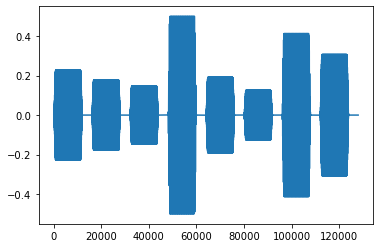

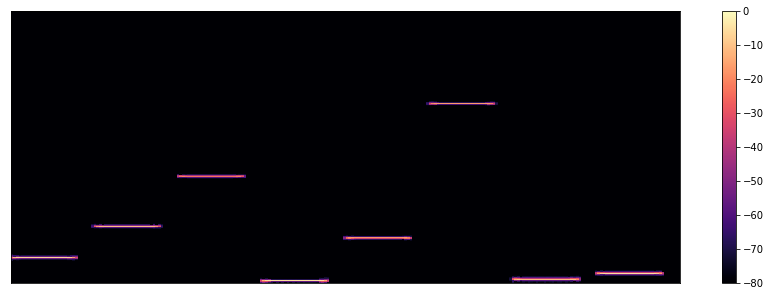

In [62]:
audio_file = '/Users/purnimakamath/appdir/Github/crowdeval-audio/audio_samples/hearing_test_audio/tonesgg_dd.wav'
audio,_ = librosa.load(audio_file, sr=16000)
plt.figure()
plt.plot(audio)
fig = plt.figure(figsize=(15,5))
D = librosa.stft(audio)  # STFT of y
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
img = librosa.display.specshow(S_db,sr=16000)
fig.colorbar(img)
Audio(audio, rate=16000)

In [238]:
soundfile.write(step2_2_file, test_tone, samplerate=16000)

In [257]:
#STEP 3: in situ hearing response estimation
# Select 1 silent tone and 7 log spaced frequencies with 
# Each clip consisting of six 15dBFS-spaced levels (-90 to -15dBFS)
start = np.log10(24)
stop = np.log10(16800)
logspaced_frequencies = np.logspace(start, stop, 7)
print(logspaced_frequencies)

dbfs_levels = [-90, -75, -60, 0, -45, -30, 0, -15, 0, -75, -45, -15]
gain_levels = [math.pow(10, i/20) for i in dbfs_levels]
print(gain_levels)

[   24.            71.51452335   213.09696042   634.98031466
  1892.09643915  5638.0156241  16800.        ]
[3.1622776601683795e-05, 0.00017782794100389227, 0.001, 1.0, 0.005623413251903491, 0.03162277660168379, 1.0, 0.1778279410038923, 1.0, 0.00017782794100389227, 0.005623413251903491, 0.1778279410038923]


In [255]:
audio_arr = np.empty((len(logspaced_frequencies), fs*len(gain_levels))) #array of all audio clips
for ind, freq in enumerate(logspaced_frequencies):
    audio = np.array([]) #audio clip
    for gain in gain_levels:
        if gain == 1.0:
            audio = np.append(audio, get_sine(gain, 0, fs, 1))
        else:
            audio = np.append(audio, get_sine(gain, freq, fs, 1))
    audio = np.reshape(audio, (1, len(audio)))
    audio_arr[ind] = audio
print(audio_arr.shape)

(7, 192000)


Frequency =  23.999999999999993


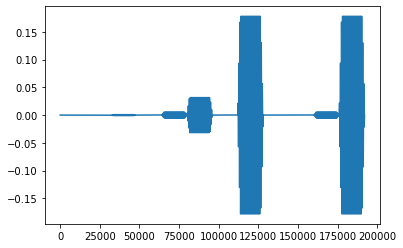

In [256]:
index = 0
print('Frequency = ', logspaced_frequencies[index])
plt.plot(audio_arr[index])
soundfile.write(step3_1_file, audio_arr[index], samplerate=16000)
Audio(audio_arr[index], rate=fs)

Frequency =  69.02261520604777


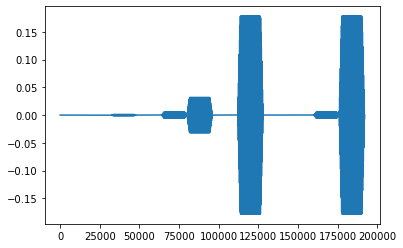

In [248]:
index = 1
print('Frequency = ', logspaced_frequencies[index])
plt.plot(audio_arr[index])
soundfile.write(step3_2_file, audio_arr[index], samplerate=16000)
Audio(audio_arr[index], rate=fs)

Frequency =  207.1357134731363


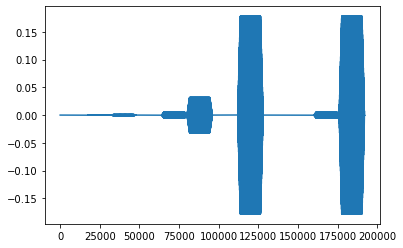

In [249]:
index = 2
print('Frequency = ', logspaced_frequencies[index])
plt.plot(audio_arr[index])
soundfile.write(step3_3_file, audio_arr[index], samplerate=16000)
Audio(audio_arr[index], rate=fs)

Frequency =  621.6108107168026


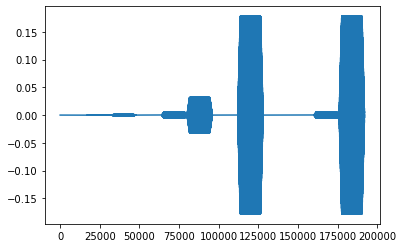

In [250]:
index = 3
print('Frequency = ', logspaced_frequencies[index])
plt.plot(audio_arr[index])
soundfile.write(step3_4_file, audio_arr[index], samplerate=16000)
Audio(audio_arr[index], rate=fs)

Frequency =  1865.4436433054452


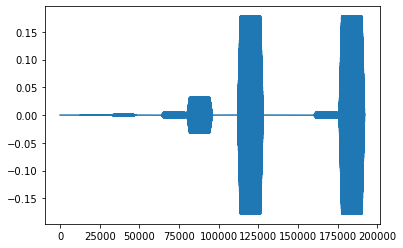

In [251]:
index = 4
print('Frequency = ', logspaced_frequencies[index])
plt.plot(audio_arr[index])
soundfile.write(step3_5_file, audio_arr[index], samplerate=16000)
Audio(audio_arr[index], rate=fs)

Frequency =  5598.165164366936


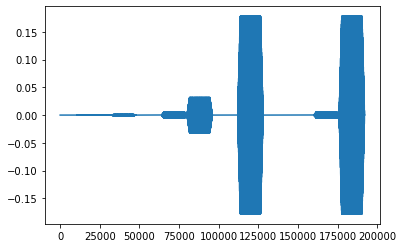

In [252]:
index = 5
print('Frequency = ', logspaced_frequencies[index])
plt.plot(audio_arr[index])
soundfile.write(step3_6_file, audio_arr[index], samplerate=16000)
Audio(audio_arr[index], rate=fs)

Frequency =  16800.00000000002


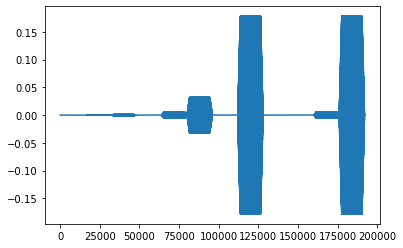

In [253]:
index = 6
print('Frequency = ', logspaced_frequencies[index])
plt.plot(audio_arr[index])
soundfile.write(step3_7_file, audio_arr[index], samplerate=16000)
Audio(audio_arr[index], rate=fs)